In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 5
AUTO = tf.data.AUTOTUNE
EPOCHS = 50
KFOLD = 10

In [2]:
def create_images_list(dir_path, class_path):
    full_path = []
    
    path = os.path.join(dir_path, class_path)
    images = os.listdir(path)
    for i in images:
        full_path.append(os.path.join(path, i))
        
    return full_path


data_dir = os.getenv('HOME') + '/aiffel/DL_Thon/jellyfish_extension'

data_barrel = create_images_list(data_dir, 'barrel_jellyfish')
data_blue = create_images_list(data_dir, 'blue_jellyfish')
data_compass = create_images_list(data_dir, 'compass_jellyfish')
data_lions_mane = create_images_list(data_dir, 'lions_mane_jellyfish') 
data_mauve_stinger = create_images_list(data_dir, 'mauve_stinger_jellyfish')
data_moon = create_images_list(data_dir, 'Moon_jellyfish')

jellyfish_classes = {0: 'Barrel', 1: 'Blue', 2: 'Compass', 3: 'Lion’s mane', 4: 'Mauve stinger', 5:'Moon'}

data = pd.concat([
    pd.DataFrame({"img": np.array(data_barrel), "label": 0}),
    pd.DataFrame({"img": np.array(data_blue), "label": 1}),
    pd.DataFrame({"img": np.array(data_compass), "label": 2}),
    pd.DataFrame({"img": np.array(data_lions_mane), "label": 3}),
    pd.DataFrame({"img": np.array(data_mauve_stinger), "label": 4}),
    pd.DataFrame({"img": np.array(data_moon), "label": 5})
], ignore_index=True)

data = shuffle(data, random_state=SEED).reset_index(drop=True)


data.head()

,img,label
0,/aiffel/aiffel/DL_Thon/jellyfish_extension/lio...,3
1,/aiffel/aiffel/DL_Thon/jellyfish_extension/blu...,1
2,/aiffel/aiffel/DL_Thon/jellyfish_extension/Moo...,5
3,/aiffel/aiffel/DL_Thon/jellyfish_extension/com...,2
4,/aiffel/aiffel/DL_Thon/jellyfish_extension/Moo...,5


In [3]:
data.shape

(2240, 2)

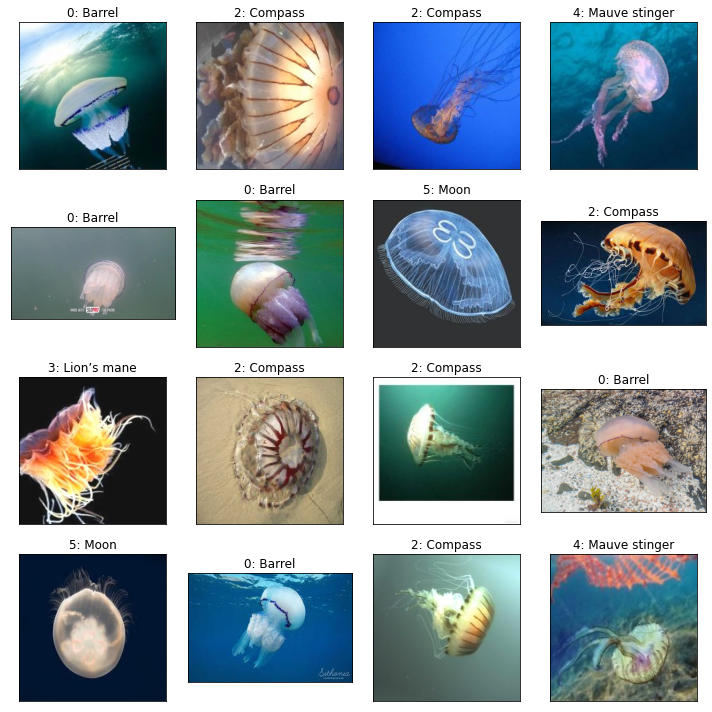

In [4]:
random_index = np.random.randint(0, len(data), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data['img'][random_index[i]]))
    ax.set_title(f"{data['label'][random_index[i]]}: {jellyfish_classes[data['label'][random_index[i]]]}")
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='label', ylabel='count'>

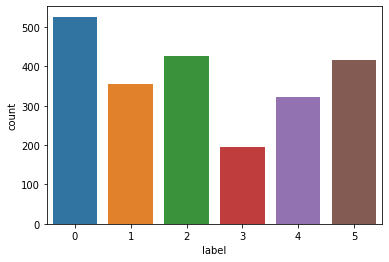

In [5]:
sns.countplot(data=data, x='label')

In [6]:
# 1. Set the `PYTHONHASHSEED` environment variable
os.environ['PYTHONHASHSEED'] = str(SEED)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
np.random.seed(SEED)

# 3. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(SEED)

In [7]:
test_idx = data.shape[0] * 20 // 100

train_df = data[test_idx:].reset_index(drop=True)
test_df = data[:test_idx].reset_index(drop=True)

print("학습(train) 및 검증(valid) 데이터프레임의 크기 -> ", train_df.shape[0])
print("테스트 데이터프레임의 크기 -> ", test_df.shape[0])

학습(train) 및 검증(valid) 데이터프레임의 크기 ->  1792
테스트 데이터프레임의 크기 ->  448


In [8]:
mobile_model = Sequential()

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

mobile_model.add(pretrained_model)

mobile_model.add(Flatten())
mobile_model.add(Dense(512, activation='relu'))
mobile_model.add(Dropout(0.2))
mobile_model.add(Dense(6, activation='softmax'))

mobile_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 2,916,934
Trainable params: 658,950
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
mobile_model.compile(loss = 'sparse_categorical_crossentropy', 
                     optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                     metrics = ['accuracy'])

In [13]:
import imghdr

# 이미지를 읽어오고 크기 조정 및 정규화를 수행하는 전처리 함수
def img_preprocessing(image, label):
    img = tf.io.read_file(image)  # 이미지 파일을 읽어옵니다.
    try:
        img = tf.io.decode_jpeg(img, channels=3)
    except tf.errors.InvalidArgumentError as e:
        # 예외가 발생한 경우, 원하는 동작을 수행하거나 무시할 수 있습니다.
        print("Error decoding JPEG:", e)
    img = tf.image.resize(img, size=(224, 224))  # 이미지 크기를 지정된 IMG_SIZE로 조정합니다.
    img = tf.cast(img, tf.float32) / 255.0  # 이미지를 부동 소수점 타입으로 변환하고 0~1 사이로 정규화합니다.
    
    return img, label

# 기본적인 데이터 증강을 수행하는 함수
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)  # 이미지를 무작위로 좌우로 뒤집습니다.
    img = tf.image.random_flip_up_down(img)  # 이미지를 무작위로 상하로 뒤집습니다.
    
    return image, label

In [14]:
from sklearn.model_selection import StratifiedKFold

all_validation_accuracy = []
all_validation_loss = []


# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=KFOLD, shuffle=True, random_state=SEED)

# Iterate over the folds
fold = 0
for train_index, val_index in kf.split(train_df['img'], train_df['label']):
    fold += 1
    print(f"Training on Fold {fold}")
    
    X_train_fold = train_df['img'][train_index]
    y_train_fold = train_df['label'][train_index]
    
    X_val_fold = train_df['img'][val_index]
    y_val_fold = train_df['label'][val_index]


    # Creating tf.pipeline
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
                     .map(img_preprocessing, num_parallel_calls = AUTO)
                     .batch(BATCH_SIZE)
                     .shuffle(BATCH_SIZE*5)
                     .prefetch(AUTO))

    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader
                          .map(img_preprocessing, num_parallel_calls = AUTO)
                          .batch(BATCH_SIZE)
                          .prefetch(AUTO))
    
    history = mobile_model.fit(train_dataset, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = validation_dataset, verbose = 0)

    # Store validation accuracy and loss
    validation_loss, validation_accuracy = mobile_model.evaluate(validation_images, steps=len(validation_images))
    all_validation_accuracy.append(validation_accuracy)
    all_validation_loss.append(validation_loss)

    # Plot the accuracy/loss graphs for each fold
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the model accuracy vs Epochs
    ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
    ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    ax[0].set_title(f'Training & Validation Accuracy - Fold {fold}', fontsize=16)
    ax[0].set_xlabel('Epochs', fontsize=16)
    ax[0].set_ylabel('Accuracy', fontsize=16)
    ax[0].legend()

    # Plot the loss vs Epochs
    ax[1].plot(epochs, loss_values, 'r', label='Training loss')
    ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
    ax[1].set_title(f'Training & Validation Loss - Fold {fold}', fontsize=16)
    ax[1].set_xlabel('Epochs', fontsize=16)
    ax[1].set_ylabel('Loss', fontsize=16)
    ax[1].legend()

Training on Fold 1


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
  (1) Invalid argument:  Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_8436]

Function call stack:
train_function -> train_function


In [ ]:
best_fold = np.argmax(all_validation_accuracy) + 1  # +1 because folds are 1-indexed
print(f'Best Fold: {best_fold}')